In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rigidbody.dynamics as dyn
import rigidbody.kinematics as kine
import rigidbody.plotter as plotter
import rigidbody.ode_solver as ode

In [2]:
plotter.set_context("paper")

In [3]:
rb = dyn.RigidBody(1.,np.array([1.]),np.array([0.,0.]))
state_init = np.array([0.1,0.1,np.pi/4,0.,0.,0.]) #three positions, three body velocities
N_t = 3000
dt = 1e-3
t_span = np.arange(N_t)*dt
state_history = np.zeros((t_span.shape[0],state_init.shape[0]))
state_history[0] = state_init
fx = 5*np.ones_like(t_span)
zeros_portion = np.pi*np.zeros((N_t//12,))
ones_portion = np.pi*np.ones((N_t//12,))
# tau_b = np.concatenate([ones_portion,ones_portion,zeros_portion,ones_portion,ones_portion,zeros_portion,ones_portion,ones_portion,zeros_portion,ones_portion,ones_portion,zeros_portion])
tau_b = 2*np.sin(2*np.pi*t_span)
force_torque_t = np.block([[fx],
                 [np.zeros_like(t_span)],
                [tau_b]])
force_torque_t = force_torque_t.T

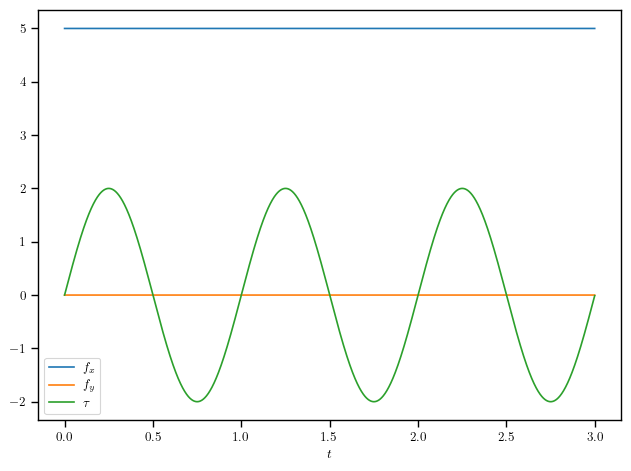

In [4]:
plt.plot(t_span,force_torque_t, label=[r"$f_x$",r"$f_y$",r"$\tau$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()

In [5]:
for i in range(t_span.shape[0]-1):
    state_history[i+1] = ode.rk_one_step(dyn.rigid_body_dynamics_two_d,state_history[i],dt,force_torque_t[i],rb)

/Users/muhammademzir/GitHub/Rigid_Body/src/rigidbody/plotter.py:64: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly = Polygon(_P[:, :2], fill=True, color=initial_color, edgecolor=initial_color)
/Users/muhammademzir/GitHub/Rigid_Body/src/rigidbody/plotter.py:68: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly = Polygon(_P[:, :2], fill=True, color=color, edgecolor=color)


Text(0, 0.5, '$y$')

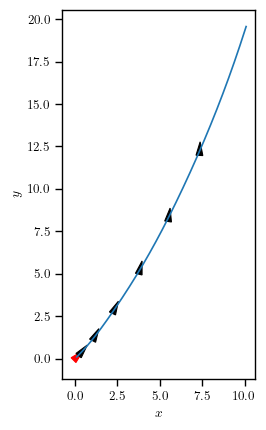

In [6]:
ax = plotter.two_d_trajectory_attitude_plot(state_history[:,:3],0.20,400,color="black",initial_color='red')
ax.set_aspect("equal")
# ax.scatter(trajectory[0,0],trajectory[0,1],s=30,color='red')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

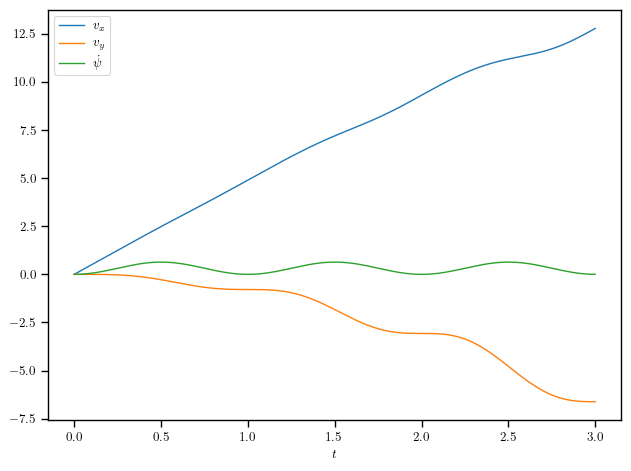

In [7]:
plt.plot(t_span,state_history[:,3:], label=[r"$v_x$",r"$v_y$",r"$\dot\psi$"],linewidth=1)
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()

In [8]:
desired_x = np.cos(2*np.pi*t_span)-1
desired_y = np.sin(2*np.pi*t_span)
desired_xy = np.block([[desired_x],[desired_y]]).T

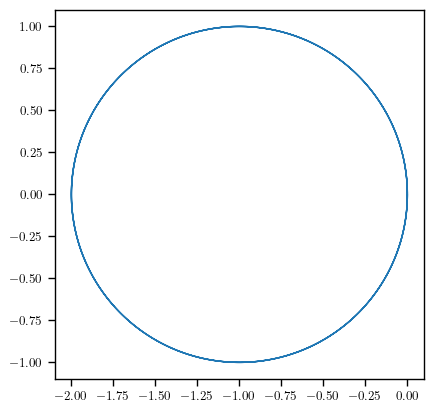

In [9]:
plt.plot(desired_xy[:,0],desired_xy[:,1],linewidth=1)
plt.gca().set_aspect('equal')

In [10]:
controlled_state_history = np.zeros_like(state_history)
controlled_state_history[0] = state_init
T = np.array([[1, 0, 0],
              [0, 0, 1],
              [0, 1, 0]])
G = np.array([[1 , 0],
              [0 , 0],
              [0 , 1]])
Ghat = T@G
#controller parameter
q_xy = 2e0
q_psi = 4e1
q_scale = 1e1
d_scale = 2e1
d_x = 1e0
d_psi=5e-1
Q = q_scale*np.diag([q_xy, q_xy, q_psi])
Ds_hat = d_scale*np.diag([d_x,d_psi, 0.])


In [11]:
u_hist = []
eta_tilde_hist = []
for i in range(t_span.shape[0]-1):
    current_state = controlled_state_history[i]
    eta = current_state[:3]
    nu = current_state[3:]
    e_xy = eta[:2] - desired_xy[i,:2]
    psi_d = np.arctan2(e_xy[1],e_xy[0])

    e_psi = eta[-1]-psi_d
    #since psi_d can only be [0,2pi] this need to be handled properly
    if e_psi < -1.5*np.pi:
        psi_d=psi_d+2*np.pi#*(controlled_trajectory[i,-1]//2*np.pi)
    elif e_psi > 1.5*np.pi:
        psi_d=psi_d-2*np.pi#*(controlled_trajectory[i,-1]//2*np.pi)
    else:
        psi_d = psi_d

    e_psi = eta[-1]-psi_d
    eta_tilde = np.array([e_xy[0],e_xy[1],e_psi])
    Jinv = kine.inverse_analytical_jacobian_2d(eta[-1])
    Jinvhat = Jinv@T.T
    nu_hat = T@nu
    corr_mat = dyn.corriolis_matrix_two_d(nu,rb)
    Chat = T@corr_mat@T.T
    Ghat_u_ = -(Ds_hat-Chat)@nu_hat - Jinvhat.T@Q@eta_tilde
    G_u_ = G@np.linalg.pinv(Ghat)@Ghat_u_

    #apply control here
    controlled_state_history[i+1] = ode.rk_one_step(dyn.rigid_body_dynamics_two_d,controlled_state_history[i],dt,G_u_,rb)

    u_hist.append(G_u_)
    eta_tilde_hist.append(eta_tilde)

u_hist = np.stack(u_hist)
eta_tilde_hist = np.stack(eta_tilde_hist)

Text(0, 0.5, '$y$')

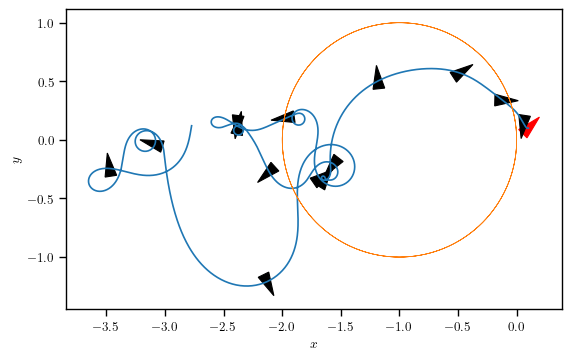

In [12]:
ax = plotter.two_d_trajectory_attitude_plot(controlled_state_history[:, :3], 0.05, 200, color="black", initial_color='red')
ax.plot(desired_xy[:,0],desired_xy[:,1],linewidth=0.5)
ax.set_aspect("equal")
# ax.scatter(trajectory[0,0],trajectory[0,1],s=30,color='red')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

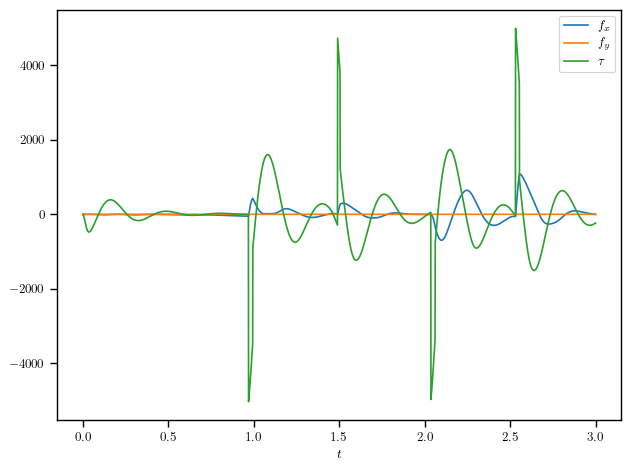

In [13]:
plt.plot(t_span[1:],u_hist, label=[r"$f_x$",r"$f_y$",r"$\tau$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()

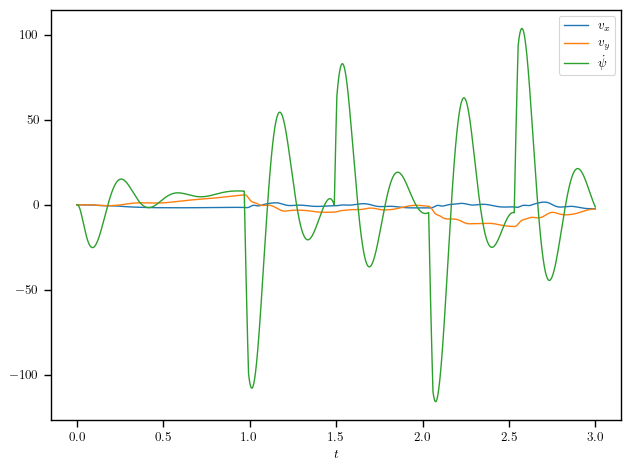

In [14]:
ax.set_ylabel(r"$y$")
plt.plot(t_span, controlled_state_history[:, 3:], label=[r"$v_x$", r"$v_y$", r"$\dot\psi$"], linewidth=1)
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()

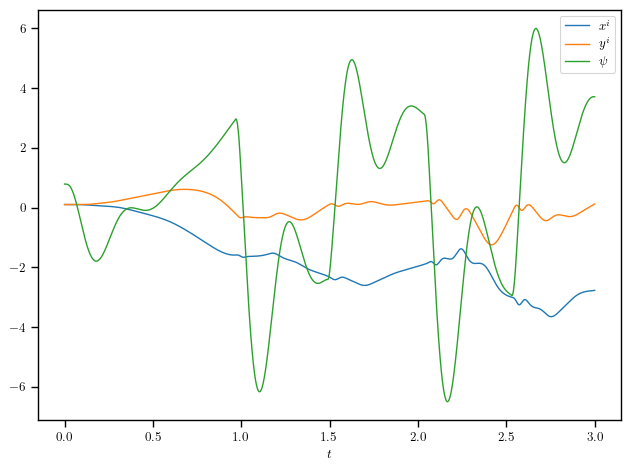

In [15]:
plt.plot(t_span, controlled_state_history[:, :3], label=[r"$x^i$", r"$y^i$", r"$\psi$"], linewidth=1)
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()

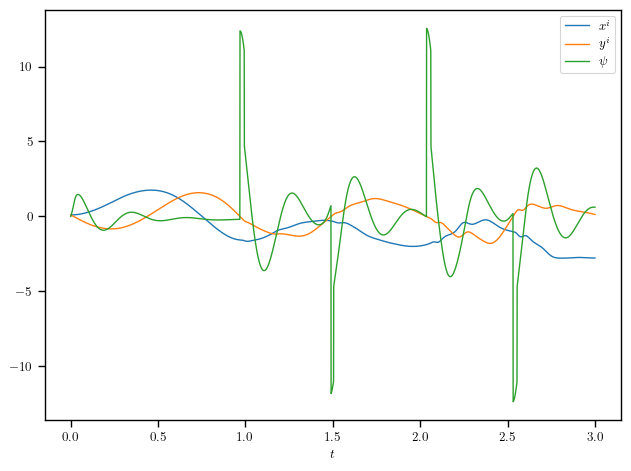

In [16]:
plt.plot(t_span[1:], eta_tilde_hist[:, :3], label=[r"$x^i$", r"$y^i$", r"$\psi$"], linewidth=1)
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()